# Removing Trends

## Introduction

Although the stationarity assumption is required in major time series modeling techniques, almost none of practical time series are stationary. In this lecture we'll discuss how you can make a time series stationary. In reality, it is almost impossible to make a series perfectly stationary, but let's try to get as close as possible!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Stationarity recap

Let's quickly rearticulate what makes a time series non-stationary. There are 2 major reasons behind non-stationarity of a time series: 

>**Trend**: Varying mean over time. 

>**Seasonality**: Certain variations at specific time-frames.

<img src="http://radacad.com/wp-content/uploads/2017/07/trendseasonal.png" alt="Drawing" style="width: 800px;"/>

In the last lab, we noticed that on average, the number of airpassengers was growing over time i.e. increase in trend. We also noticed that there was some seasonality, reflecting specific times in the year when people travel more. 

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series in order to get a stationary series. Statistical modeling techniques can then be implemented on these series. The final step would be to convert the modeled values into the original scale by applying trend and seasonality constraints back.

## Eliminating the trend

In this lecture, we'll cover 3 key ways to eliminate trends:
- Taking the log transformation
- Subtracting the rolling mean
- Differencing

### Log Transformation

One of the first tricks to enforce stationarity can be a simple log transformation to make the time series more "uniform" over time. For example, in this case we can clearly see that there is a significant positive trend, which might not be linear, or when there is a certain heteroskedasticity. 
The advantage of taking the log is that taking a transformation like this, higher values are penalized more than lower values. Alternatives for the log are the square root, cube root, etc. 

Lets look at our generated sales data again, and compare the plot with the plot where we take a log transform.

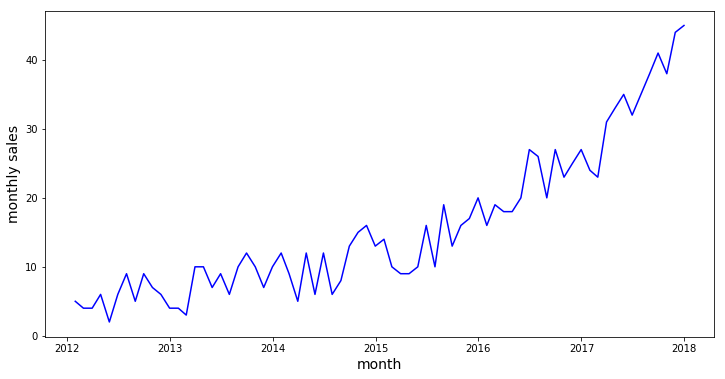

In [1]:
# Import necessary packages
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# Generated monthly sales
years = pd.date_range('2012-01', periods=72, freq="M")
index = pd.DatetimeIndex(years)

np.random.seed(3456)
sales= np.random.randint(-4, high=4, size=72)
bigger = np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,
                   3,3,3,3,3,3,3,3,7,7,7,7,7,7,7,7,7,7,7,
                   11,11,11,11,11,11,11,11,11,11,18,18,18,
                   18,18,18,18,18,18,26,26,26,26,26,36,36,36,36,36])
final_series = sales+bigger+6
data = pd.Series(final_series, index=index)
fig = plt.figure(figsize=(12,6))
plt.plot(data, color="blue")
plt.xlabel("month", fontsize=14)
plt.ylabel("monthly sales", fontsize=14)
plt.show()

Now, use numPy's `np.log()` to get the log transform of the time series and compare the output with original time series. 

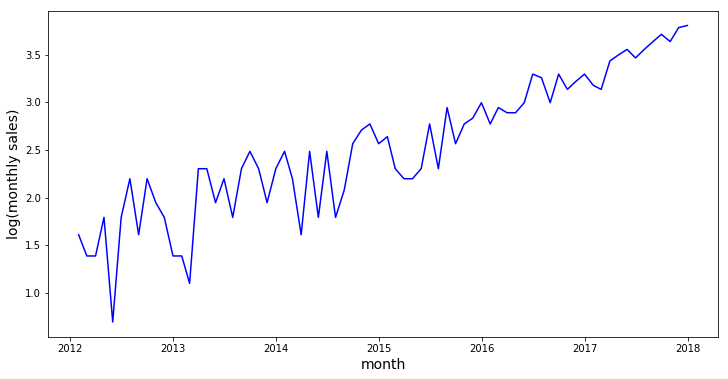

In [2]:
data = pd.Series(np.log(final_series), index=index)
fig = plt.figure(figsize=(12,6))
plt.plot(data, color="blue")
plt.xlabel("month", fontsize=14)
plt.ylabel("log(monthly sales)", fontsize=14)
plt.show()

You can notice here that this series is not stationary (yet), but taking the log did make the trend more linear, which might be a first step in the right direction. The issue is however that there seems to be more heteroscedasticity in the model now. Let's look at what happens if you take the square root of this series.

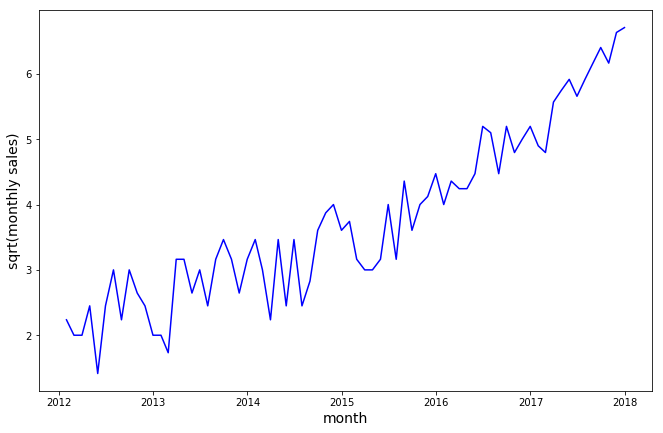

In [3]:
data = pd.Series(np.sqrt(final_series), index=index)
fig = plt.figure(figsize=(11,7))
plt.plot(data, color="blue")
plt.xlabel("month", fontsize=14)
plt.ylabel("sqrt(monthly sales)", fontsize=14)
plt.show()

This looks a little better, but still not ideal in this case. You'll notice that for some data the log or sqrt transform is really the way to go. For now, let's move on to the next option: subtracting the rolling mean.

### Subtracting the rolling mean

#### The rolling mean

From previously, you know that you can look at the rolling mean and the rolling to visually check if the mean changes or variance changes over time.

The rolling mean can actually serve another purpose as well. You can calculate the rolling mean and subtract it from the time series to make sure your time series is stationary. The code to do this can be found below:

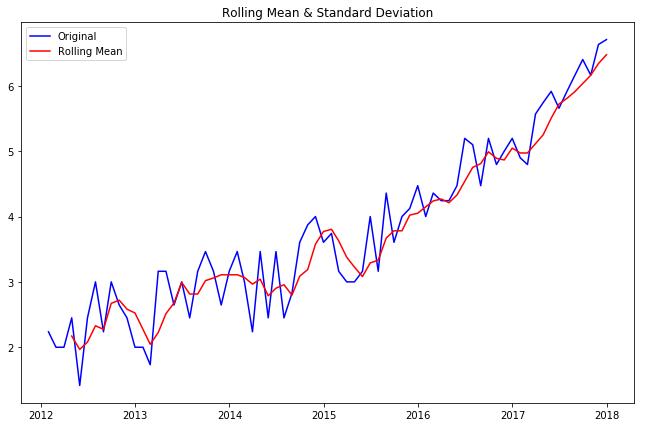

In [4]:
rolmean = data.rolling(window = 4).mean()
fig = plt.figure(figsize=(11,7))
orig = plt.plot(data, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 8 values, rolling mean is not defined for the first 7 values. Let's subtract these values and check for Nans for undefined values.

In [5]:
# Subtract the moving average from the original data and check head for Nans
data_minus_rolmean = data - rolmean
data_minus_rolmean.head(15)

2012-01-31         NaN
2012-02-29         NaN
2012-03-31         NaN
2012-04-30    0.278100
2012-05-31   -0.551712
2012-06-30    0.371191
2012-07-31    0.671702
2012-08-31   -0.038875
2012-09-30    0.328611
2012-10-31   -0.074704
2012-11-30   -0.133338
2012-12-31   -0.523810
2013-01-31   -0.273810
2013-02-28   -0.313334
2013-03-31    0.938696
Freq: M, dtype: float64

In [6]:
# Drop the NaN values from timeseries calculated above
data_minus_rolmean.dropna(inplace=True)

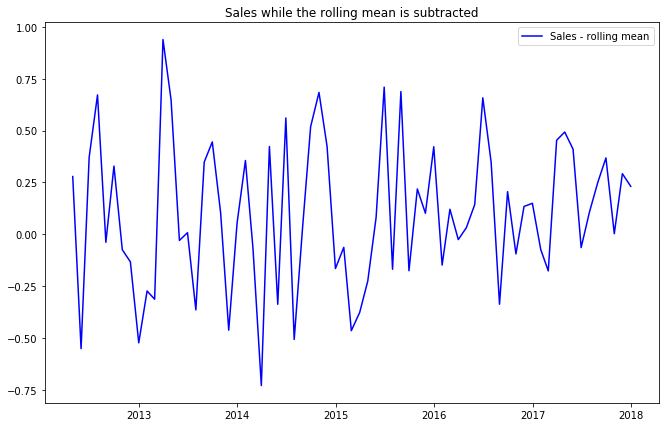

In [7]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_rolmean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

This seems to be more or less stationary! Note that you can change the window length, which will affect what your eventual time series will look like. You'll experiment with this in the lab!

#### The weighted rolling mean

A drawback of the rolling mean approach is that the window has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, it may be difficult to come up with an exact number. So we take a "weighted rolling mean" (or weighted moving average, WMA for short) where more recent values are given a higher weight. There are several techniques for assigning weights. A popular one is **Exponentially Weighted Moving Average** where weights are assigned to all the previous values with an exponential decay factor.This can be implemented in Pandas with `DataFrame.ewm()` method. Details can be found [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html).

Note that here the parameter ‘halflife’ is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay which are discussed in the link shared above.

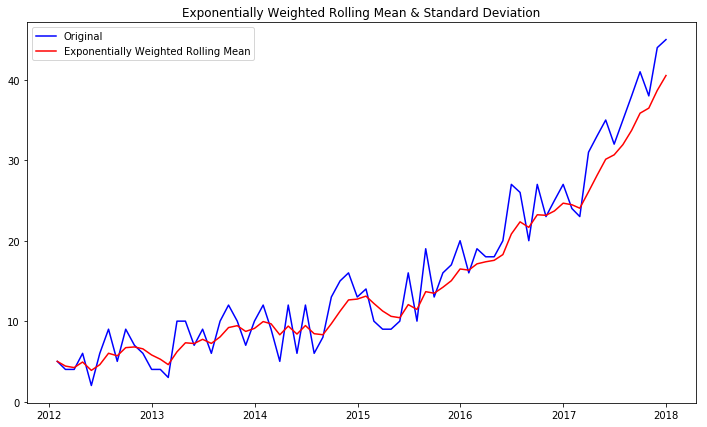

In [13]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
exp_rolmean = data.ewm(halflife = 2).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(data, color='blue',label='Original')
mean = plt.plot(exp_rolmean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

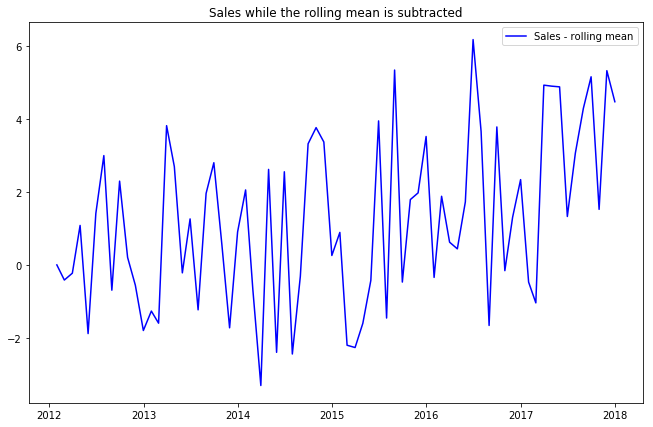

In [14]:
# Subtract the moving average from the original data and check head for Nans
data_minus_exp_rolmean = data - exp_rolmean
data_minus_exp_rolmean.head(15)

fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_rolmean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

For our sales data, subtracting the weighted mean does not seem to have a better effect than simply subtracting the rolling mean. Still, this might be better in some cases. 

### Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of an observation at a particular time instant with that at the previous instant (i.e. a co-called 1-period "lag"). 

This mostly works pretty well in improving stationarity. First order differencing can be done in Pandas using the `.diff()` function with periods = 1 (denoting a 1-period lag). Details on `.diff()` can be found [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html).

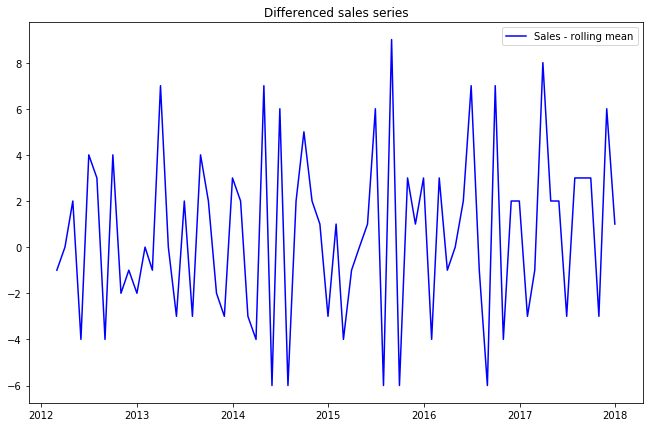

In [15]:
data_diff = data.diff(periods=1)
data_diff.head(10)

fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

This seems to work pretty well if you want to make the series stationary!

Differencing is a very popular tool to remove seasonal trends from time series as well. Look at the plot below. Here, we differenced our temperature data by taking differences of exactly one year, which removes the cyclical seasonality from the time series data! Pretty magical!

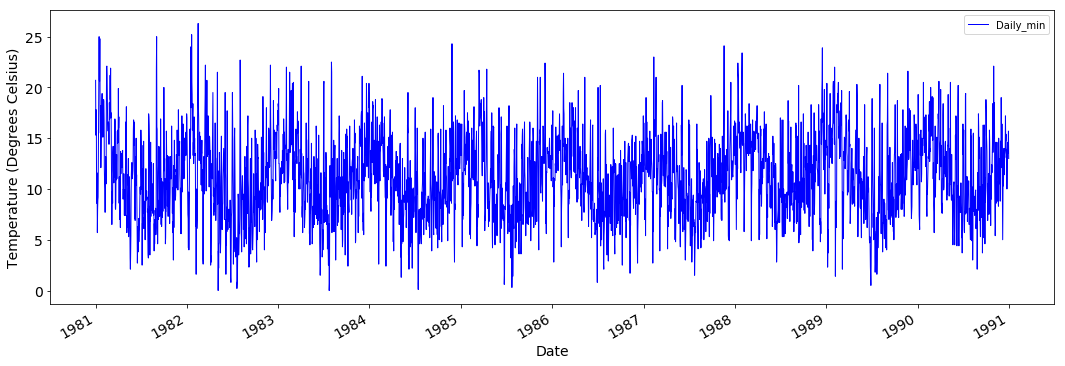

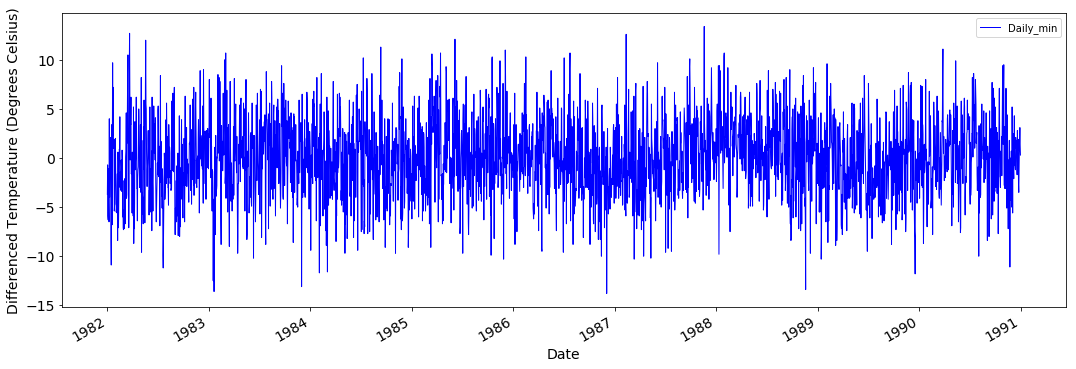

In [16]:
data = pd.read_csv("min_temp.csv")
data.Date = pd.to_datetime(data.Date)
data.set_index('Date', inplace=True)

data.plot(figsize=(18,6), color='blue', linewidth=1, fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature (Degrees Celsius)', fontsize=14);

data_diff = data.diff(periods=365)
data_diff.plot(figsize=(18,6), color='blue', linewidth=1, fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Temperature (Degrees Celsius)', fontsize=14);

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing. Let's move on to some practice!